In [1]:
import pandas as pd
import numpy as np

from os.path import exists
from os import mkdir

import matplotlib as mpl
import matplotlib.pyplot as plt
import seaborn as sns

import open3d as o3d
from utils import *

#%env OPEN3D_CPU_RENDERING true

mpl.rcParams["figure.dpi"] = 300
mpl.rcParams["legend.fontsize"] = 12
mpl.rcParams["font.size"] = 12

PLOTDIR = "plots"
DATADIR = "data"

DIRS = [PLOTDIR, DATADIR]

def plot_savepath(filename):
    return PLOTDIR + f"/{filename}"

def data_path(filename):
    return DATADIR + f"/{filename}"

for d in DIRS:
    if not exists(d):
        mkdir(d)
              
output_dir = f"figures/experiments/"

In [2]:
Organoid_Names = ['HW8D60SUPB15_VOL_1.xls',
                  'HW8D60SUPB15_VOL_2.xls',
                  'HW8D60SUPB15_VOL_3.xls', 
                  'HW8D60KASUMI2_VOL_1.xls',
                  'HW8D60KASUMI2_VOL_2.xls', 
                  'HW8D60KASUMI2_VOL_3.xls',
                  '697_1_MAP2.xls',
                  '697_2_MAP2.xls', 
                  '697_3_MAP2.xls',
                  'VOL_1857_1.xls',
                  'VOL_1857_2.xls', 
                  'VOL_1857_3.xls',
                  'AICS-31_CD34+_Vol_(2).xls',
                  'Day10CD34V.xls',
                  'VOL_CD34_other.xls',
                  'BCELL_1_MAP2.xls',
                  'BCELL_2_MAP2.xls', 
                  'BCELL_3_MAP2.xls']

organoid_pts = []

for name in Organoid_Names:
    df = pd.read_excel(data_path(name), header = None, skiprows =1)
    df = df.rename(columns = df.iloc[0]).drop(df.index[0])
    df_drop = df.drop(columns=['Unit', 'Category', 'Collection', 'Time', 'ID'])
    pts = df_drop.to_numpy()
    organoid_pts.append(pts)

In [3]:
Entity_Names = ['HW8D60SUPB15_DOTS_1.xls',
                'HW8D60SUPB15_DOTS_2.xls',
                'HW8D60SUPB15_DOTS_3.xls', 
                'HW8D60KASUMI2_DOTS_1.xls',
                'HW8D60KASUMI2_DOTS_2.xls', 
                'HW8D60KASUMI2_DOTS_3.xls',
                '697_1_CFSE.xls',
                '697_2_CFSE.xls', 
                '697_3_CFSE.xls',
                'DOTS_1857_1.xls',
                'DOTS_1857_2.xls', 
                'DOTS_1857_3.xls',
                'AICS-31_CD34+_Dots_(2).xls',
                'Day10CD34D.xls',
                'DOTS_CD34_other.xls',
                'BCELL_1_CFSE.xls',
                'BCELL_2_CFSE.xls', 
                'BCELL_3_CFSE.xls']

entity_pts = []

for name in Entity_Names:
    df = pd.read_excel(data_path(name), header = None, skiprows =1)
    df = df.rename(columns = df.iloc[0]).drop(df.index[0])
    df_drop = df.drop(columns=['Unit', 'Category', 'Collection', 'Time', 'ID'])
    pts = df_drop.to_numpy()
    entity_pts.append(pts)

In [4]:
assert len(organoid_pts)==len(entity_pts)

distances = []

for index in range(len(organoid_pts)):
    # Organoids
    pcd_org = o3d.geometry.PointCloud()
    pcd_org.points = o3d.utility.Vector3dVector(organoid_pts[index])
    pcd_org.compute_convex_hull()
    pcd_org.estimate_normals()
    pcd_org.orient_normals_consistent_tangent_plane(10)
    
    with o3d.utility.VerbosityContextManager(
            o3d.utility.VerbosityLevel.Debug) as cm:
        mesh_org, densities = o3d.geometry.TriangleMesh.create_from_point_cloud_poisson(
            pcd_org, depth=10, scale=10, linear_fit=True)
    # print(mesh)
    mesh_org.paint_uniform_color([0.8, 0.2, 0])
    mesh_org.compute_vertex_normals()
    mesh_org.filter_smooth_simple(number_of_iterations=5)
    
    mesh_to_fill_org = o3d.t.geometry.TriangleMesh.from_legacy(mesh_org)
    mesh_to_fill_org.fill_holes(hole_size=10)
    final_mesh_org = mesh_to_fill_org.to_legacy()
    
    # Entities
    pcd_ent = o3d.geometry.PointCloud()
    pcd_ent.points = o3d.utility.Vector3dVector(entity_pts[index])
    pcd_ent.compute_convex_hull()
    pcd_ent.estimate_normals()
    pcd_ent.orient_normals_consistent_tangent_plane(10)
    
    with o3d.utility.VerbosityContextManager(
            o3d.utility.VerbosityLevel.Debug) as cm:
        mesh_ent, densities = o3d.geometry.TriangleMesh.create_from_point_cloud_poisson(
            pcd_ent, depth=10, scale=10, linear_fit=True)
    # print(mesh)
    mesh_ent.paint_uniform_color([0.8, 0.2, 0])
    mesh_ent.compute_vertex_normals()
    mesh_ent.filter_smooth_simple(number_of_iterations=5)
    
    mesh_to_fill_ent = o3d.t.geometry.TriangleMesh.from_legacy(mesh_ent)
    mesh_to_fill_ent.fill_holes(hole_size=10)
    final_mesh_ent = mesh_to_fill_ent.to_legacy()
    
    # Calculation of distances
    mesh_org_toleg = o3d.t.geometry.TriangleMesh.from_legacy(final_mesh_org)
    mesh_ent_toleg = o3d.t.geometry.TriangleMesh.from_legacy(final_mesh_ent)
    
    scene = o3d.t.geometry.RaycastingScene()
    mesh_ids = {}
    mesh_ids[scene.add_triangles(mesh_org_toleg)] = 'surface'
    mesh_ids[scene.add_triangles(mesh_ent_toleg)] = 'cells'

    query_point = np.asarray(entity_pts[index]).astype('float32')

    unsigned_distance = scene.compute_distance(query_point)
    distances.append(unsigned_distance.numpy())

[Open3D DEBUG] Input Points / Samples: 13962 / 10444
[Open3D DEBUG] #   Got kernel density: 0.00345302 (s), 366.012 (MB) / 366.012 (MB) / 366 (MB)
[Open3D DEBUG] #     Got normal field: 0.03319 (s), 369.832 (MB) / 369.832 (MB) / 369 (MB)
[Open3D DEBUG] Point weight / Estimated Area: 2.427893e-06 / 3.389824e-02
[Open3D DEBUG] #       Finalized tree: 0.0387471 (s), 378.141 (MB) / 378.141 (MB) / 378 (MB)
[Open3D DEBUG] #  Set FEM constraints: 0.043231 (s), 378.375 (MB) / 378.375 (MB) / 378 (MB)
[Open3D DEBUG] #Set point constraints: 0.00412989 (s), 379.227 (MB) / 379.227 (MB) / 379 (MB)
[Open3D DEBUG] Leaf Nodes / Active Nodes / Ghost Nodes: 197023 / 216952 / 8217
[Open3D DEBUG] Memory Usage: 379.227 MB
[Open3D DEBUG] # Linear system solved: 0.128543 (s), 389.195 (MB) / 389.195 (MB) / 389 (MB)
[Open3D DEBUG] Got average: 0.00502992 (s), 389.641 (MB) / 389.641 (MB) / 389 (MB)
[Open3D DEBUG] Iso-Value: 5.170907e-01 = 7.219621e+03 / 1.396200e+04
[Open3D DEBUG] #          Total Solve:       1

/ Solved in:  0.001 /  0.012 /  0.008	(416.156 MB)	Nodes: 35937
          GS: 1.4033e-01 -> 1.4033e-01 -> 1.4564e-03 (1.0e-02) [8]
Cycle[0] Depth[ 6/10]:	Updated constraints / Got system / Solved in:  0.001 /  0.001 /  0.001	(416.156 MB)	Nodes: 2848
            GS: 1.2367e-01 -> 1.2367e-01 -> 6.1612e-04 (5.0e-03) [8]
Cycle[0] Depth[ 7/10]:	Updated constraints / Got system / Solved in:  0.002 /  0.001 /  0.002	(416.164 MB)	Nodes: 4904
              GS: 1.1928e-01 -> 1.1928e-01 -> 9.4092e-04 (7.9e-03) [8]
Cycle[0] Depth[ 8/10]:	Updated constraints / Got system / Solved in:  0.002 /  0.002 /  0.004	(416.219 MB)	Nodes: 10744
                GS: 9.0853e-02 -> 9.0853e-02 -> 4.5292e-04 (5.0e-03) [8]
Cycle[0] Depth[ 9/10]:	Updated constraints / Got system / Solved in:  0.003 /  0.004 /  0.006	(416.223 MB)	Nodes: 17176
                  GS: 5.9105e-02 -> 5.9105e-02 -> 2.0262e-04 (3.4e-03) [8]
Cycle[0] Depth[10/10]:	Updated constraints / Got system / Solved in:  0.002 /  0.005 /  0.009	(416.828 

[Open3D DEBUG] #          Total Solve:       1.0 (s),     613.6 (MB)
[Open3D WARNING] Ignoring attribute 'normals' for TensorMap with primary key 'indices'
[Open3D DEBUG] Input Points / Samples: 19928 / 12227
[Open3D DEBUG] #   Got kernel density: 0.00303411 (s), 607.879 (MB) / 613.625 (MB) / 614 (MB)
[Open3D DEBUG] #     Got normal field: 0.0291531 (s), 607.879 (MB) / 613.625 (MB) / 614 (MB)
[Open3D DEBUG] Point weight / Estimated Area: 1.293769e-06 / 2.578223e-02
[Open3D DEBUG] #       Finalized tree: 0.0317979 (s), 607.879 (MB) / 613.625 (MB) / 614 (MB)
[Open3D DEBUG] #  Set FEM constraints: 0.0397549 (s), 607.879 (MB) / 613.625 (MB) / 614 (MB)
[Open3D DEBUG] #Set point constraints: 0.00369096 (s), 607.887 (MB) / 613.625 (MB) / 614 (MB)
[Open3D DEBUG] Leaf Nodes / Active Nodes / Ghost Nodes: 178214 / 198800 / 4873
[Open3D DEBUG] Memory Usage: 607.887 MB
Cycle[0] Depth[ 0/10]:	Updated constraints / Got system / Solved in:  0.000 /  0.000 /  0.000	(450.906 MB)	Nodes: 8
CG: 7.3564e-03 

Depth[10/10]:	Updated constraints / Got system / Solved in:  0.002 /  0.006 /  0.009	(539.977 MB)	Nodes: 16784
                    GS: 3.8960e-02 -> 3.8960e-02 -> 7.5069e-05 (1.9e-03) [8]
Cycle[0] Depth[ 0/10]:	Updated constraints / Got system / Solved in:  0.000 /  0.000 /  0.000	(587.750 MB)	Nodes: 8
CG: 9.3683e-03 -> 9.3683e-03 -> 2.9488e-06 (3.1e-04) [32672]
Cycle[0] Depth[ 1/10]:	Updated constraints / Got system / Solved in:  0.001 /  0.000 /  0.000	(587.750 MB)	Nodes: 27
  GS: 4.5972e-02 -> 4.5972e-02 -> 6.4233e-04 (1.4e-02) [8]
Cycle[0] Depth[ 2/10]:	Updated constraints / Got system / Solved in:  0.001 /  0.000 /  0.000	(587.750 MB)	Nodes: 125
    GS: 7.0694e-02 -> 7.0694e-02 -> 1.5923e-03 (2.3e-02) [8]
Cycle[0] Depth[ 3/10]:	Updated constraints / Got system / Solved in:  0.001 /  0.001 /  0.000	(587.750 MB)	Nodes: 729
      GS: 1.2142e-01 -> 1.2142e-01 -> 2.6476e-03 (2.2e-02) [8]
Cycle[0] Depth[ 4/10]:	Updated constraints / Got system / Solved in:  0.001 /  0.004 /  0.001	(587.

[Open3D DEBUG] Got average: 0.00640202 (s), 626.879 (MB) / 626.879 (MB) / 626 (MB)
[Open3D DEBUG] Iso-Value: 5.085181e-01 = 1.383322e+04 / 2.720300e+04
[Open3D DEBUG] #          Total Solve:       1.4 (s),     631.8 (MB)
[Open3D WARNING] Ignoring attribute 'normals' for TensorMap with primary key 'indices'
[Open3D DEBUG] Input Points / Samples: 806 / 757
[Open3D DEBUG] #   Got kernel density: 0.00113988 (s), 625.094 (MB) / 631.801 (MB) / 633 (MB)
[Open3D DEBUG] #     Got normal field: 0.00257397 (s), 625.094 (MB) / 631.801 (MB) / 633 (MB)
[Open3D DEBUG] Point weight / Estimated Area: 3.031059e-05 / 2.443033e-02
[Open3D DEBUG] #       Finalized tree: 0.015166 (s), 625.094 (MB) / 631.801 (MB) / 633 (MB)
[Open3D DEBUG] #  Set FEM constraints: 0.0267019 (s), 625.094 (MB) / 631.801 (MB) / 633 (MB)
[Open3D DEBUG] #Set point constraints: 0.00114703 (s), 625.094 (MB) / 631.801 (MB) / 633 (MB)
[Open3D DEBUG] Leaf Nodes / Active Nodes / Ghost Nodes: 82531 / 84528 / 9793
[Open3D DEBUG] Memory Usa

Cycle[0] Depth[ 5/10]:	[Open3D DEBUG] # Linear system solved: 0.087781 (s), 790.227 (MB) / 790.227 (MB) / 790 (MB)
[Open3D DEBUG] Got average: 0.00371385 (s), 790.227 (MB) / 790.227 (MB) / 790 (MB)
[Open3D DEBUG] Iso-Value: 5.174069e-01 = 9.266758e+02 / 1.791000e+03
Updated constraints / Got system / Solved in:  0.001 /  0.012 /  0.014	(624.875 MB)	Nodes: 35937
          GS: 2.5655e-01 -> 2.5655e-01 -> 2.7164e-03 (1.1e-02) [8]
Cycle[0] Depth[ 6/10]:	Updated constraints / Got system / Solved in:  0.001 /  0.001 /  0.001	(624.875 MB)	Nodes: 2992
            GS: 2.4470e-01 -> 2.4470e-01 -> 1.1465e-03 (4.7e-03) [8]
Cycle[0] Depth[ 7/10]:	Updated constraints / Got system / Solved in:  0.002 /  0.001 /  0.002	(624.875 MB)	Nodes: 6208
              GS: 2.0315e-01 -> 2.0315e-01 -> 8.9238e-04 (4.4e-03) [8]
Cycle[0] Depth[ 8/10]:	Updated constraints / Got system / Solved in:  0.002 /  0.003 /  0.005	(624.875 MB)	Nodes: 16848
                GS: 1.7218e-01 -> 1.7218e-01 -> 1.8406e-03 (1.1e-02) [8

[Open3D DEBUG] #          Total Solve:       1.2 (s),     803.4 (MB)
[Open3D WARNING] Ignoring attribute 'normals' for TensorMap with primary key 'indices'
[Open3D DEBUG] Input Points / Samples: 977 / 858
[Open3D DEBUG] #   Got kernel density: 0.00100803 (s), 803.363 (MB) / 803.363 (MB) / 803 (MB)
[Open3D DEBUG] #     Got normal field: 0.00341606 (s), 803.363 (MB) / 803.363 (MB) / 803 (MB)
[Open3D DEBUG] Point weight / Estimated Area: 1.778434e-05 / 1.737530e-02
[Open3D DEBUG] #       Finalized tree: 0.0155911 (s), 803.363 (MB) / 803.363 (MB) / 803 (MB)
[Open3D DEBUG] #  Set FEM constraints: 0.0275359 (s), 803.363 (MB) / 803.363 (MB) / 803 (MB)
[Open3D DEBUG] #Set point constraints: 0.00216508 (s), 803.363 (MB) / 803.363 (MB) / 803 (MB)
[Open3D DEBUG] Leaf Nodes / Active Nodes / Ghost Nodes: 84288 / 88896 / 7433
[Open3D DEBUG] Memory Usage: 803.363 MB
[Open3D DEBUG] # Linear system solved: 0.0789859 (s), 803.363 (MB) / 803.363 (MB) / 803 (MB)
[Open3D DEBUG] Got average: 0.00363898 (s),

001	(847.098 MB)	Nodes: 4913
        GS: 1.3642e-01 -> 1.3642e-01 -> 1.7619e-03 (1.3e-02) [8]
Cycle[0] Depth[ 5/10]:	Updated constraints / Got system / Solved in:  0.001 /  0.012 /  0.007	(847.098 MB)	Nodes: 35937
          GS: 1.0704e-01 -> 1.0704e-01 -> 1.5176e-03 (1.4e-02) [8]
Cycle[0] Depth[ 6/10]:	Updated constraints / Got system / Solved in:  0.001 /  0.001 /  0.001	(847.098 MB)	Nodes: 2248
            GS: 1.0833e-01 -> 1.0833e-01 -> 4.2776e-04 (3.9e-03) [8]
Cycle[0] Depth[ 7/10]:	Updated constraints / Got system / Solved in:  0.002 /  0.001 /  0.002	(847.098 MB)	Nodes: 3472
              GS: 7.5278e-02 -> 7.5278e-02 -> 4.2799e-04 (5.7e-03) [8]
Cycle[0] Depth[ 8/10]:	Updated constraints / Got system / Solved in:  0.002 /  0.001 /  0.003	(847.098 MB)	Nodes: 5608
                GS: 4.4872e-02 -> 4.4872e-02 -> 2.3032e-04 (5.1e-03) [8]
Cycle[0] Depth[ 9/10]:	Updated constraints / Got system / Solved in:  0.003 /  0.002 /  0.004	(847.098 MB)	Nodes: 4496
                  GS: 4.0206e-

[Open3D DEBUG] # Linear system solved: 0.0756571 (s), 852.512 (MB) / 852.512 (MB) / 852 (MB)
[Open3D DEBUG] Got average: 0.00363612 (s), 852.512 (MB) / 852.512 (MB) / 852 (MB)
[Open3D DEBUG] Iso-Value: 5.187270e-01 = 8.273695e+02 / 1.595000e+03
[Open3D DEBUG] #          Total Solve:       1.0 (s),     852.6 (MB)
[Open3D WARNING] Ignoring attribute 'normals' for TensorMap with primary key 'indices'
[Open3D DEBUG] Input Points / Samples: 21474 / 18741
[Open3D DEBUG] #   Got kernel density: 0.00523996 (s), 846.59 (MB) / 852.559 (MB) / 852 (MB)
[Open3D DEBUG] #     Got normal field: 0.0530729 (s), 846.59 (MB) / 852.559 (MB) / 852 (MB)
[Open3D DEBUG] Point weight / Estimated Area: 1.846969e-06 / 3.966181e-02
[Open3D DEBUG] #       Finalized tree: 0.0451429 (s), 846.59 (MB) / 852.559 (MB) / 852 (MB)
[Open3D DEBUG] #  Set FEM constraints: 0.0500300 (s), 846.59 (MB) / 852.559 (MB) / 852 (MB)
[Open3D DEBUG] #Set point constraints: 0.00578499 (s), 846.59 (MB) / 852.559 (MB) / 852 (MB)
[Open3D DE

                 GS: 4.4831e-02 -> 4.4831e-02 -> 2.0474e-04 (4.6e-03) [8]
Cycle[0] Depth[ 0/10]:	Updated constraints / Got system / Solved in:  0.000 /  0.000 /  0.000	(849.512 MB)	Nodes: 8
CG: 8.2498e-03 -> 8.2498e-03 -> 1.5297e-07 (1.9e-05) [32672]
Cycle[0] Depth[ 1/10]:	Updated constraints / Got system / Solved in:  0.001 /  0.000 /  0.000	(849.512 MB)	Nodes: 27
  GS: 1.0608e-02 -> 1.0608e-02 -> 7.7996e-06 (7.4e-04) [8]
Cycle[0] Depth[ 2/10]:	Updated constraints / Got system / Solved in:  0.001 /  0.000 /  0.000	(849.512 MB)	Nodes: 125
    GS: 2.1965e-02 -> 2.1965e-02 -> 3.1098e-05 (1.4e-03) [8]
Cycle[0] Depth[ 3/10]:	Updated constraints / Got system / Solved in:  0.001 /  0.001 /  0.000	(849.512 MB)	Nodes: 729
      GS: 4.0044e-02 -> 4.0044e-02 -> 7.5627e-05 (1.9e-03) [8]
Cycle[0] Depth[ 4/10]:	Updated constraints / Got system / Solved in:  0.001 /  0.003 /  0.002	(849.512 MB)	Nodes: 4913
        GS: 5.7559e-02 -> 5.7559e-02 -> 1.1574e-04 (2.0e-03) [8]
Cycle[0] Depth[ 5/10]:	Update

In [5]:
dict_keys = ['A', 'B', 'C', 'D', 'E', 'F', 'G', 'H', 'I', 'J', 'K', 'L', 'M', 'N', 'O', 'P', 'Q', 'R']

d = dict(zip(dict_keys, distances))

In [6]:
df = pd.DataFrame(dict([ (k,pd.Series(v)) for k,v in d.items() ]))
df = df.melt(var_name = "Entity", value_name = "Distance to Surface (\u03BCm)")
display(df)

Entity  Distance to Surface (μm)
0          A                  1.885051
1          A                  2.056081
2          A                  0.900723
3          A                  0.245485
4          A                  0.137147
...      ...                       ...
72517      R                       NaN
72518      R                       NaN
72519      R                       NaN
72520      R                       NaN
72521      R                       NaN

[72522 rows x 2 columns]

In [7]:
df.loc[df['Entity'] == 'A', 'Types'] = 'Repeat 1'  
df.loc[df['Entity'] == 'B', 'Types'] = 'Repeat 2'  
df.loc[df['Entity'] == 'C', 'Types'] = 'Repeat 3'  
df.loc[df['Entity'] == 'D', 'Types'] = 'Repeat 1'  
df.loc[df['Entity'] == 'E', 'Types'] = 'Repeat 2'  
df.loc[df['Entity'] == 'F', 'Types'] = 'Repeat 3'
df.loc[df['Entity'] == 'G', 'Types'] = 'Repeat 1'  
df.loc[df['Entity'] == 'H', 'Types'] = 'Repeat 2'
df.loc[df['Entity'] == 'I', 'Types'] = 'Repeat 3'  
df.loc[df['Entity'] == 'J', 'Types'] = 'Repeat 1'  
df.loc[df['Entity'] == 'K', 'Types'] = 'Repeat 2'  
df.loc[df['Entity'] == 'L', 'Types'] = 'Repeat 3'  
df.loc[df['Entity'] == 'M', 'Types'] = 'Repeat 1'  
df.loc[df['Entity'] == 'N', 'Types'] = 'Repeat 2'
df.loc[df['Entity'] == 'O', 'Types'] = 'Repeat 3'  
df.loc[df['Entity'] == 'P', 'Types'] = 'Repeat 1'
df.loc[df['Entity'] == 'Q', 'Types'] = 'Repeat 2'  
df.loc[df['Entity'] == 'R', 'Types'] = 'Repeat 3'

df['Entity'] = df['Entity'].replace({
              'A':'SUPB15',
              'B':'SUPB15',
              'C':'SUPB15',
              'D':'KASUMI',
              'E':'KASUMI',
              'F':'KASUMI',
              'G':'697',
              'H':'697',
              'I':'697',
              'J':'PDX',
              'K':'PDX',
              'L':'PDX',
              'M':'HPSC',
              'N':'HPSC',
              'O':'HPSC',
              'P':'BLYMPHOCYTE',
              'Q':'BLYMPHOCYTE',
              'R':'BLYMPHOCYTE'}) 

df[np.isfinite(df["Distance to Surface (\u03BCm)"])]
df_final = df[df["Distance to Surface (\u03BCm)"] > 0.0001]
display(df_final)

#df_filtered below filters for measurements above 10μm
df_filtered = df_final[df_final['Distance to Surface (μm)'] > 10]
df_filtered.to_excel("df_filtered.xlsx", sheet_name='filtered')
display(df_filtered)

#Below are lines of code to extract the number of values for each 'Entity' given as "count of values for each entity"
entity_counts = df_filtered['Entity'].value_counts()

# Print the results
print("Count of values for each entity:")
print(entity_counts)

# Group by 'Entity' and 'Types' and calculate the count for each group
entity_type_counts = df_filtered.groupby(['Entity', 'Types']).size().reset_index(name='Count')

# Print the results
print("Count of values for each entity and replicate:")
print(entity_type_counts)

Entity  Distance to Surface (μm)     Types
0           SUPB15                  1.885051  Repeat 1
1           SUPB15                  2.056081  Repeat 1
2           SUPB15                  0.900723  Repeat 1
3           SUPB15                  0.245485  Repeat 1
4           SUPB15                  0.137147  Repeat 1
...            ...                       ...       ...
69416  BLYMPHOCYTE                  4.822407  Repeat 3
69417  BLYMPHOCYTE                  7.199219  Repeat 3
69418  BLYMPHOCYTE                  3.627583  Repeat 3
69419  BLYMPHOCYTE                  0.760324  Repeat 3
69420  BLYMPHOCYTE                 23.748123  Repeat 3

[26560 rows x 3 columns]

Entity  Distance to Surface (μm)     Types
22          SUPB15                 19.032297  Repeat 1
23          SUPB15                 19.351938  Repeat 1
24          SUPB15                 12.655099  Repeat 1
25          SUPB15                 25.445148  Repeat 1
26          SUPB15                 13.022331  Repeat 1
...            ...                       ...       ...
69351  BLYMPHOCYTE                 19.889431  Repeat 3
69391  BLYMPHOCYTE                 12.534343  Repeat 3
69393  BLYMPHOCYTE                 38.622421  Repeat 3
69407  BLYMPHOCYTE                 98.213928  Repeat 3
69420  BLYMPHOCYTE                 23.748123  Repeat 3

[1886 rows x 3 columns]

Count of values for each entity:
PDX            709
697            328
SUPB15         272
HPSC           221
BLYMPHOCYTE    216
KASUMI         140
Name: Entity, dtype: int64
Count of values for each entity and replicate:
         Entity     Types  Count
0           697  Repeat 1     76
1           697  Repeat 2    192
2           697  Repeat 3     60
3   BLYMPHOCYTE  Repeat 1     44
4   BLYMPHOCYTE  Repeat 2    102
5   BLYMPHOCYTE  Repeat 3     70
6          HPSC  Repeat 1     84
7          HPSC  Repeat 2     68
8          HPSC  Repeat 3     69
9        KASUMI  Repeat 1     34
10       KASUMI  Repeat 2     28
11       KASUMI  Repeat 3     78
12          PDX  Repeat 1    306
13          PDX  Repeat 2    234
14          PDX  Repeat 3    169
15       SUPB15  Repeat 1    157
16       SUPB15  Repeat 2     43
17       SUPB15  Repeat 3     72


In [8]:
#This is optional to change any names as above
df.rename(columns={'A': 'Leukemia Replicate 1',
                   'B': 'Leukemia Replicate 2',
                   'C': 'Leukemia Replicate 3',
                   'D': 'Leukemia Replicate 1',
                   'E': 'Leukemia Replicate 2',
                   'F': 'Leukemia Replicate 3',
                   'G': 'Leukemia Replicate 1',
                   'H': 'Leukemia Replicate 2',
                   'I': 'Leukemia Replicate 3',
                   'J': 'Leukemia Replicate 1',
                   'K': 'Leukemia Replicate 2',
                   'L': 'Leukemia Replicate 3',
                   'M': 'HPSC Replicate 1',
                   'N': 'HPSC Replicate 2',
                   'O': 'HPSC Replicate 3',
                   'P': 'B Lymphocyte Replicate 1',
                   'Q': 'B Lymphocyte Replicate 2',
                   'R': 'B Lymphocyte Replicate 3'}, inplace=True)

#df.to_excel("unmelted_leukemiabcell_data.xlsx", sheet_name='unmeltedLEUK') 
df_leukemia = df.melt(var_name = "Entity", value_name = "Distance to Surface (\u03BCm)")
#df_leukemia.to_excel("melted_leukemiabcell_data.xlsx", sheet_name='meltedLEUK') 

/var/folders/9w/4xkqf_xd0kg5ycr900ldx_9w0000gn/T/ipykernel_8903/1592582114.py:22: FutureWarning: This dataframe has a column name that matches the 'value_name' column name of the resulting Dataframe. In the future this will raise an error, please set the 'value_name' parameter of DataFrame.melt to a unique name.
  df_leukemia = df.melt(var_name = "Entity", value_name = "Distance to Surface (\u03BCm)")


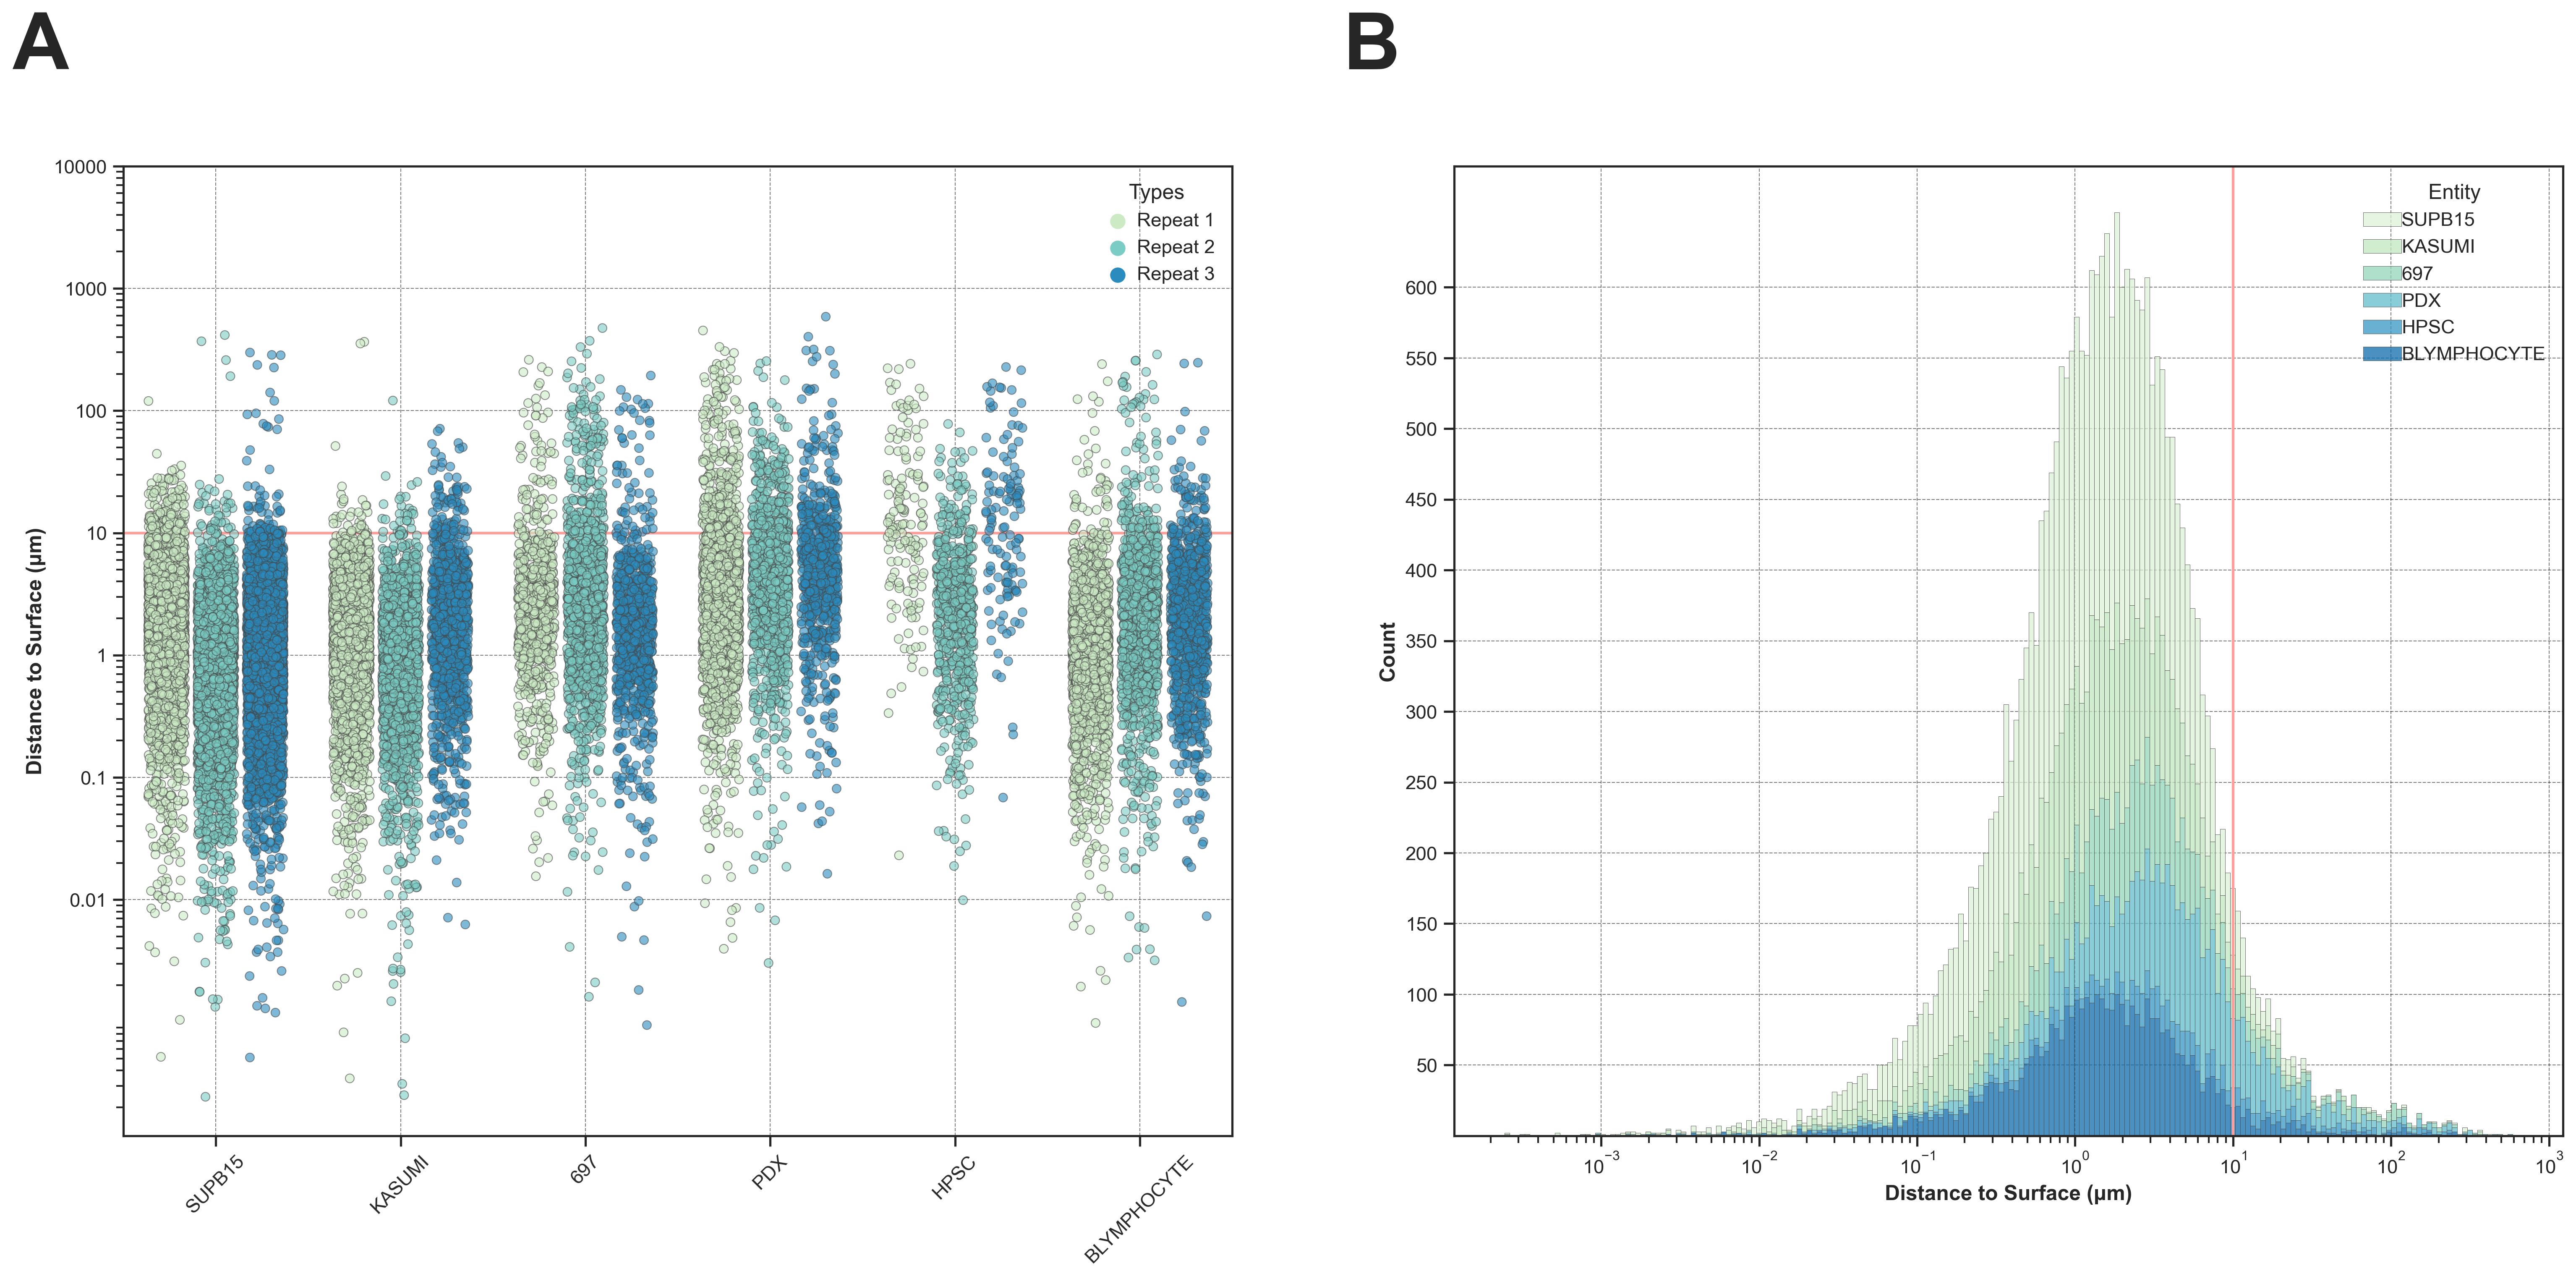

In [9]:
sns.set_theme(style="ticks", palette="pastel")
fig, axes = plt.subplots(1, 2, figsize=(25, 10), gridspec_kw={'width_ratios': [2, 2]})
g = sns.stripplot(ax=axes[0], data=df_final,
              x="Entity", y="Distance to Surface (\u03BCm)",
              hue="Types", palette="GnBu", linewidth=0.5,
              size=5, alpha=0.6, jitter=.30, dodge=True,
                 )
    
g.set_yscale("log")
# the non-logarithmic labels
ticks = [0.01, 0.1, 1, 10, 100, 1000, 10000]
g.set_yticks(ticks)
g.set_yticklabels(ticks)

g.tick_params(axis='x', rotation=45)
g.xaxis.label.set_visible(False)

sns.move_legend(
    g, loc="best", ncol=1, frameon=False, columnspacing=5, handletextpad=0
)

g.axhline(10, color='r')

g = sns.histplot(
    df_final,
    x="Distance to Surface (\u03BCm)", hue="Entity",
    bins=200,
    multiple="stack",
    palette="GnBu",
    element="bars",
    edgecolor=".3",
    common_norm=False,
    kde=False,
    pmax=1000,
    linewidth=.2,
    stat="count",
    log_scale=True,
)

sns.move_legend(
    g, loc="best", ncol=1, frameon=False, columnspacing=5, handletextpad=0)

axes[0].grid(color='black', alpha=0.5, linestyle='dashed', linewidth=0.5)
axes[0].set_xlabel('Entity', fontweight ='bold')
axes[0].set_ylabel('Distance to Surface (\u03BCm)', fontweight ='bold')
ticks = [10, 20, 30, 40, 50, 60, 70, 80, 90, 100]
g.set_yticks(ticks)
g.set_yticklabels(ticks)

axes[1].grid(color='black', alpha=0.5, linestyle='dashed', linewidth=0.5)
axes[1].set_xlabel('Distance to Surface (\u03BCm)', fontweight ='bold')
axes[1].set_ylabel('Count', fontweight ='bold')
ticks = [50, 100, 150, 200, 250, 300, 350, 400, 450, 500, 550, 600]
g.set_yticks(ticks)
g.set_yticklabels(ticks)

g.axvline(x=10, color='r')

texts = ['A', 'B']
ax = fig.get_axes()
for a,l in zip(ax, texts):
    a.annotate(l, xy=(-0.1, 1.1), xycoords="axes fraction", fontsize=45, weight = 'bold')

plt.savefig(plot_savepath('LeukemiaGroup_vs_Healthy.pdf'), bbox_inches='tight')
plt.savefig(plot_savepath('LeukemiaGroup_vs_Healthy.png'), dpi=300, bbox_inches='tight')

plt.show()

In [10]:
#vis = o3d.visualization.Visualizer()
#vis.create_window(visible=False) #works for me with False, on some systems needs to be true
#vis.add_geometry(final_mesh_org)
#vis.update_geometry(final_mesh_org)
#vis.poll_events()
#vis.update_renderer()
#vis.capture_screen_image(plot_savepath('1857.png'), do_render=True)
#vis.destroy_window()